In [168]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [169]:
Nb_model = 10

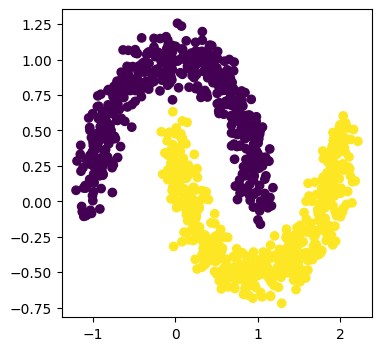

In [184]:
X, Y = make_moons(n_samples=1000, noise=0.1)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

In [185]:
indices = np.argsort(X_train[:, 0])

X_train = X_train[indices]
Y_train = Y_train[indices]

limiteParAgent = np.random.choice(range(1, X_train.shape[0]), Nb_model-1, replace=False)
limiteParAgent = np.sort(limiteParAgent)
print(limiteParAgent)

X_agent = []
Y_agent = []

for i in range(Nb_model):
    if i == 0:
        X_agent.append(X_train[:limiteParAgent[i]])
        Y_agent.append(Y_train[:limiteParAgent[i]])
    elif i == Nb_model-1:
        X_agent.append(X_train[limiteParAgent[i-1]:])
        Y_agent.append(Y_train[limiteParAgent[i-1]:])
    else:
        X_agent.append(X_train[limiteParAgent[i-1]:limiteParAgent[i]])
        Y_agent.append(Y_train[limiteParAgent[i-1]:limiteParAgent[i]])




[203 256 260 298 350 385 443 503 556]


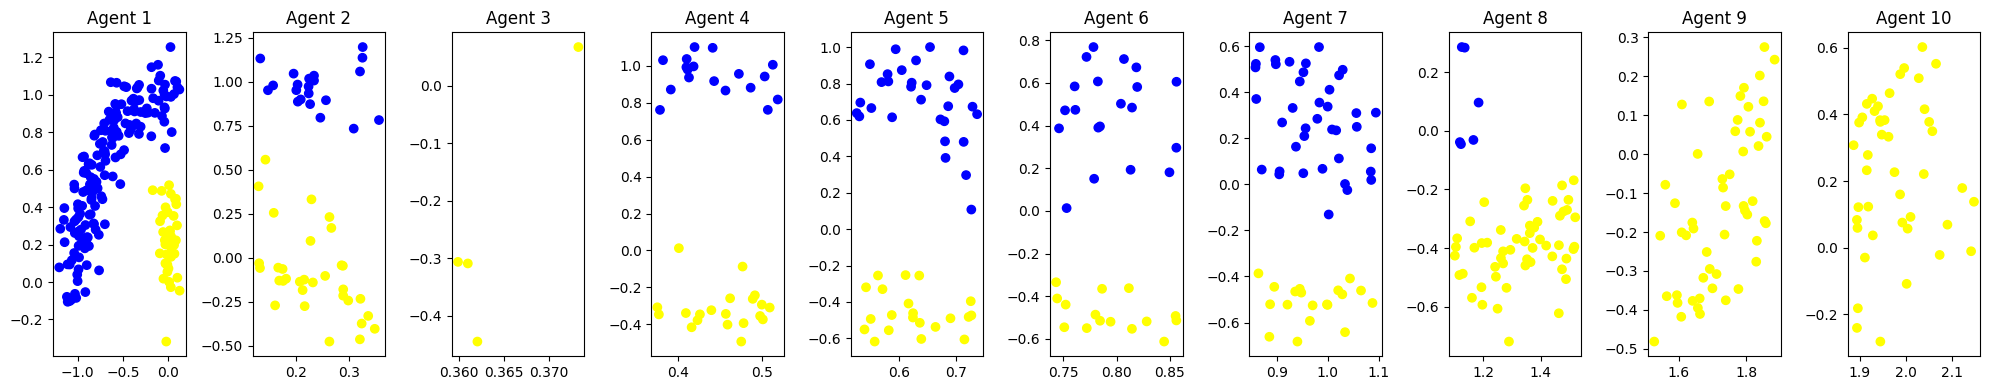

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=Nb_model, figsize=(20, 4))

for i in range(Nb_model):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

(53, 2)


In [188]:
G = np.zeros((Nb_model, Nb_model))
for i in range(Nb_model):
    for j in range(Nb_model):
        if j == i+1 or j == i-1:
            G[i,j] = 1
    
D = np.zeros(Nb_model)
c = np.zeros(Nb_model)

maxSize = np.max([x.shape[0] for x in X_agent])
print(maxSize)
for i in range(Nb_model):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize



203


supposons que l'on réveille d'abord les agents chacun leur tour.

In [189]:
T = 1000
mu = 0.1



## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In [190]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """The sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        The array on which to elementwise compute the sigmoid function

    Returns
    -------
    np.ndarray
        The sigmoid value (1 / (1 + exp(-z)))
    """
    z = np.clip(z, -10, 10)
    return   1 / (1 + np.exp(-z))

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

In [191]:
def cost(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """Computes the cost using theta as the parameters for logistic regression.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    float
        The sum of the cost for each sample
    """
    z = X @ theta
    return -np.sum( y * np.log(sigmoid(z)) + (1 - y)*np.log(1 - sigmoid(z)) )

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

In [192]:
def compute_grad(theta: np.ndarray, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    """Computes the gradient of the cost with respect to the parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    np.ndarray
        The gradient, of shape (n_features,)
    """
    return np.sum((sigmoid(X @ theta) - y) * X.T, axis=1)

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf


Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $

In [193]:
def stepForward(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    for i in range(Nb_model):
        L_i = 0.25 * np.sum(np.linalg.norm(X_agent[i], axis=1)**2)
        alpha = 1/(1 + mu * c[i] * L_i)
        terme = 0
        for j in range(Nb_model):
            if G[i,j] == 1:
                terme += (G[i,j] / D[i]) * theta[j]
        terme -= mu * c[i] * compute_grad(theta[i], X_agent[i], Y_agent[i])
        
        theta[i] = (1-alpha) * theta[i] + alpha * terme
    
    return theta

In [195]:
thetas = [np.zeros(X_agent[i].shape[1]) for i in range(Nb_model)]

costs = np.zeros((T, Nb_model))

for i in range(T):
    thetas = stepForward(thetas, X_agent, Y_agent)
    if i % 100 == 0 :
        for j in range(Nb_model):
            costs[i,j] = cost(thetas[j], X_train, Y_train)
        print(f'Iteration {i+1} : {np.mean(costs[i])} and {np.std(costs[i])}')

Iteration 1 : 343.8098567690767 and 44.22258698874618
Iteration 101 : 172.34405352834258 and 17.518624626303286
Iteration 201 : 170.55560908868392 and 16.46408876060094
Iteration 301 : 170.3328475994393 and 16.263540920847174
Iteration 401 : 170.29786376305566 and 16.23010869914849
Iteration 501 : 170.2921499514176 and 16.224595412535376
Iteration 601 : 170.2912106512171 and 16.22368764169703
Iteration 701 : 170.29105607327273 and 16.223538213555532
Iteration 801 : 170.29103063034245 and 16.223513617209047
Iteration 901 : 170.2910264424134 and 16.223509568599848
